In [13]:
#імпортуємо потрібні бібліотеки
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pathlib import Path
import pandas as pd
import math
import seaborn as sns

from torchmetrics import MeanAbsolutePercentageError
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

<H1>EDA і робота з даними</H1>

In [5]:
#завантажуємо дані та позбуваємось NaN
ltv_frame = pd.read_csv("data.csv")
ltv_frame = ltv_frame.dropna().drop_duplicates()
ltv_frame.to_csv("clean_data.csv")
ltv_frame.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_135,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_203,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0


<P>На нашу думку, у цьому завдання потрібно відстежувати динаміку змін кількості дій користувача, тому ми використовуємо різницю між сьомим та третім днем по відповідних метриках (на деяких - різницю між третім та першим). Також припускається, що декілька перших днів користувач тільки знайомився з грою, тому визначати його подальшу поведінку будуть саме дії, які він здійснив після періоду ознайомлення</P>
<P>Через такий підхід маємо й інші характеристики для передбачення: приріст прибутків від третього до тридцятого дня</P>

In [2]:
#визначаємо потрібні нам стовпці
#колонки з категоріями
columns_categorical = ['media_source', 'country_code', 'platform']

#колонки з числами
columns_float = ['total_sessions_diff', 'chapters_finished_diff', 'chapters_opened_diff', 'chapters_closed_diff',
'diamonds_received_diff', 'diamonds_spent_diff', 'app_sub_ltv_diff', 'app_iap_ltv_diff', 'ad_ltv_diff']
columns_target = ['target_sub_ltv_diff', 'target_iap_ltv_diff', 'target_ad_ltv_diff']
useful_frame = pd.DataFrame(columns=columns_float + columns_target)

In [6]:
#рахуємо створені метрики
useful_frame['total_sessions_diff'] = ltv_frame['total_sessions_day7'] - ltv_frame['total_sessions_day3']
useful_frame['chapters_finished_diff'] = ltv_frame['chapters_finished_day7'] - ltv_frame['chapters_finished_day3']
useful_frame['chapters_opened_diff'] = ltv_frame['chapters_opened_day7'] - ltv_frame['chapters_opened_day3']
useful_frame['chapters_closed_diff'] = ltv_frame['chapters_closed_day7'] - ltv_frame['chapters_closed_day3']
useful_frame['diamonds_received_diff'] = ltv_frame['diamonds_received_day7'] - ltv_frame['diamonds_received_day3']
useful_frame['diamonds_spent_diff'] = ltv_frame['diamonds_spent_day7'] - ltv_frame['diamonds_spent_day3']
useful_frame['app_sub_ltv_diff'] = ltv_frame['app_sub_ltv_day3'] - ltv_frame['app_sub_ltv_day1']
useful_frame['app_iap_ltv_diff'] = ltv_frame['app_iap_ltv_day3'] - ltv_frame['app_iap_ltv_day1']
useful_frame['ad_ltv_diff'] = ltv_frame['ad_ltv_day3'] - ltv_frame['ad_ltv_day1']
useful_frame['target_sub_ltv_diff'] = ltv_frame['target_sub_ltv_day30'] - ltv_frame['app_sub_ltv_day3']
useful_frame['target_iap_ltv_diff'] = ltv_frame['target_iap_ltv_day30'] - ltv_frame['app_iap_ltv_day3']
useful_frame['target_ad_ltv_diff'] = ltv_frame['target_ad_ltv_day30'] - ltv_frame['ad_ltv_day3']

<P>Дізнаємось розподіл прирісту витрачених кристалів та приблизну залежність прибутку за покупки від нього</P>

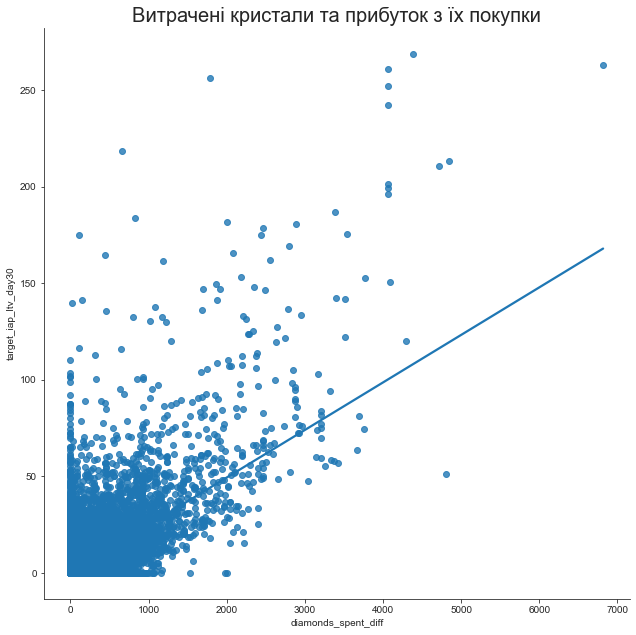

In [26]:
# графік залежності diamonds_spent_day_diff та target_iap_ltv_day30
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)
sns.regplot(x=useful_frame["diamonds_spent_diff"], y=ltv_frame["target_iap_ltv_day30"], ci=None, fit_reg=True, ax=ax)
plt.title("Витрачені кристали та прибуток з їх покупки", fontdict={'size':20})
sns.despine()

<P>Аналогічно, дізнаємось розподіл прирісту закінчених глав та приблизну залежність прибутку за рекламу від нього</P>

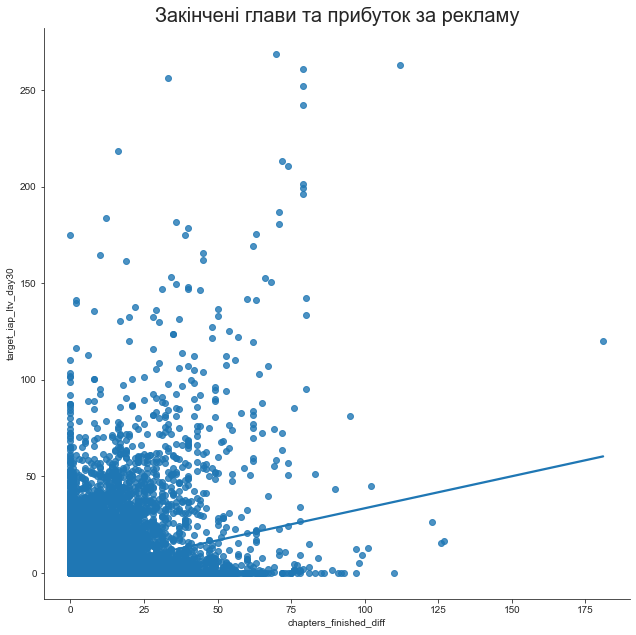

In [27]:
# графік залежності двох метрик: chapters_finished_day_diff та target_iap_ltv_day30
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)
sns.regplot(x=useful_frame["chapters_finished_diff"], y=ltv_frame["target_iap_ltv_day30"], ci=None, fit_reg=True, ax=ax)
plt.title("Закінчені глави та прибуток за рекламу", fontdict={'size':20})
sns.despine()

<P>Як і очікувалось, простежується залежність між наведеними характеристиками.</P>
<P>Так само буде й зі всіма іншими характеристиками: чим більше дії здійснює гравець, тим більше можна очікувати з нього прибуток</P>

<P>На графіку нижче видно, що багато користувачів не заходять в гру після перших трьох днів. Тому нас цікавлять лише ті, хто заходить знову (точки, що знаходяться над діагоналлю)</P>

C:\Users\tunki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Лінійна залежність\n total_sessions_day7 від total_sessions_day3'}, xlabel='total_sessions_day3', ylabel='total_sessions_day7'>

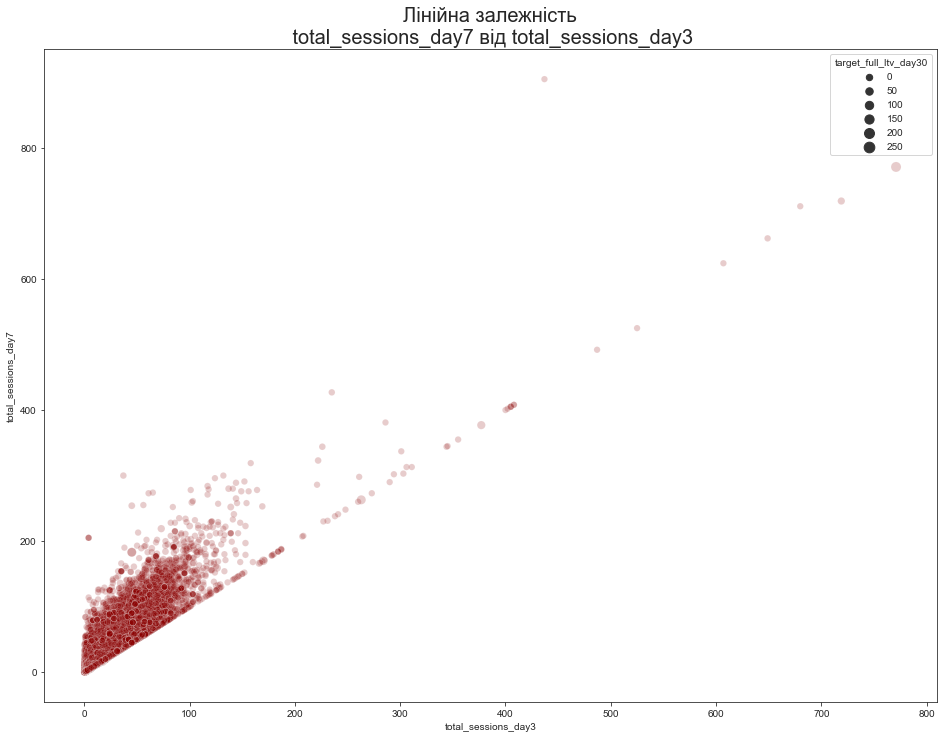

In [28]:
title = 'Залежність\n total_sessions_day7 від total_sessions_day3'

plt.figure(figsize=(16, 12))
plt.title(title, fontsize=20)
sns.scatterplot("total_sessions_day3", "total_sessions_day7", data=ltv_frame, size='target_full_ltv_day30', sizes=(40,120), color = 'darkred', alpha = .2)

In [29]:
useful_frame.columns

Index(['total_sessions_diff', 'chapters_finished_diff', 'chapters_opened_diff',
       'chapters_closed_diff', 'diamonds_received_diff', 'diamonds_spent_diff',
       'app_sub_ltv_diff', 'app_iap_ltv_diff', 'ad_ltv_diff',
       'target_sub_ltv_diff', 'target_iap_ltv_diff', 'target_ad_ltv_diff'],
      dtype='object')

<P>Перевіримо залежність між порахованими характеристиками та цільовими</P>

<AxesSubplot:title={'center':'Кореляційна матриця до датафрейму'}>

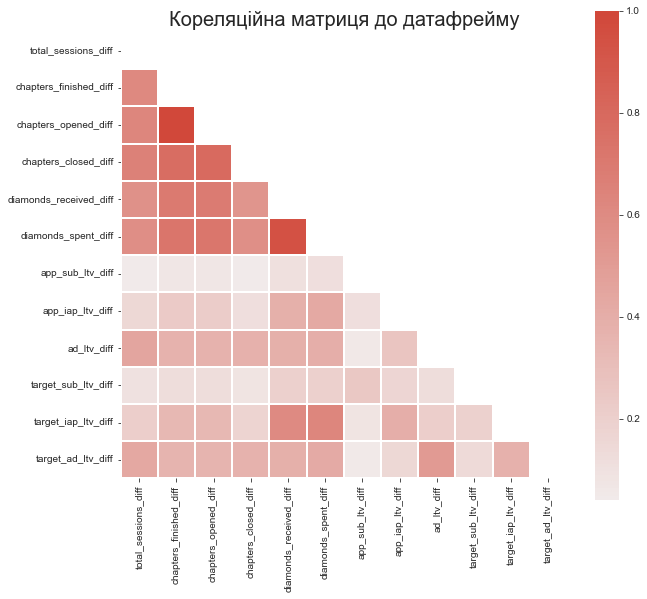

In [32]:
corr = useful_frame.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

title = 'Кореляційна матриця до датафрейму'

plt.figure(figsize=(10, 9))
plt.title(title, fontsize=20)
cmap = sns.diverging_palette(160, 15, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=0.1)

<P>Оскільки країна користувача впливає на його платоспроможність, ми вирішили розбити країни на три категорії за цим показником. Схожа закономірність простежується також і на джерелах трафіку, тому щодо них було прийнято аналогічне рішення з двома категоріями</P>

In [33]:
#групуємо дані та рахуємо середнє по країнах, джерелах та платформах щоби визначити категорії
income_per_country = ltv_frame[['country_code', 'target_full_ltv_day30']].groupby('country_code').agg(
    average_ltv = pd.NamedAgg(column='target_full_ltv_day30', aggfunc=np.mean)
)['average_ltv']
income_per_country = income_per_country.sort_values(ascending=False)

income_per_source = ltv_frame[['media_source', 'target_full_ltv_day30']].groupby('media_source').agg(
    average_ltv = pd.NamedAgg(column='target_full_ltv_day30', aggfunc=np.mean)
)['average_ltv']
income_per_source = income_per_source.sort_values(ascending=False)

income_per_platform = ltv_frame[['platform', 'target_full_ltv_day30']].groupby('platform').agg(
    average_ltv = pd.NamedAgg(column='target_full_ltv_day30', aggfunc=np.mean)
)['average_ltv']
income_per_platform = income_per_platform.sort_values(ascending=False)

Text(0.5, 1.0, 'Average income per platforms')

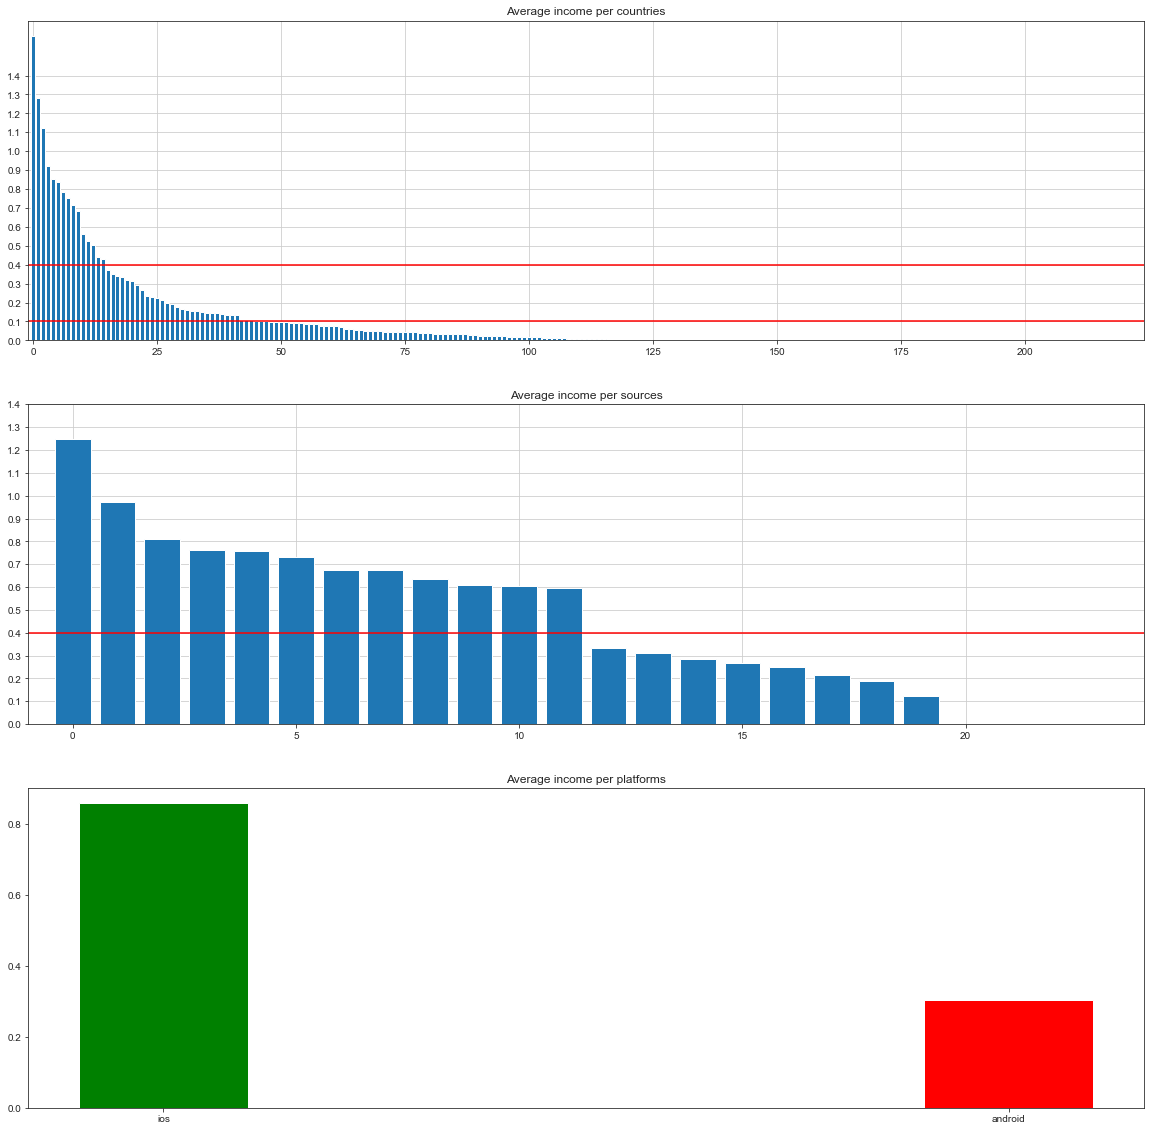

In [34]:
#визначаємо категорії
country_categories = [0.1, 0.4]
country_count = len(income_per_country)
source_categories = [0.4]
source_count = len(income_per_source)

#візуалізуємо результати
fig, ax = plt.subplots(nrows = 3, figsize=(20, 20))

ax[0].bar(range(country_count), income_per_country.values)
for category in country_categories:
    ax[0].plot([-1, country_count], [category, category], color="r")
ax[0].set_xlim(-1, country_count)
ax[0].yaxis.set_ticks(np.arange(0, 1.5, 0.1))
ax[0].set_title("Average income per countries")
ax[0].grid()

ax[1].bar(range(len(income_per_source)), income_per_source.values)
for category in source_categories:
    ax[1].plot([-1, source_count], [category, category], color="r")
ax[1].set_xlim(-1, source_count)
ax[1].yaxis.set_ticks(np.arange(0, 1.5, 0.1))
ax[1].set_title("Average income per sources")
ax[1].grid()

ax[2].bar(income_per_platform.index, income_per_platform.values, width = 0.2, color = ['green', 'red'])
ax[2].set_title("Average income per platforms")

In [ ]:
#створюємо словник категорій
category_dict = {}
for id, value in income_per_country.items():
    category = 0
    for threshold in country_categories:
        if value >= threshold: category += 1
        else: break
    category_dict[id] = category

for id, value in income_per_source.items():
    category = 0
    for threshold in source_categories:
        if value >= threshold: category += 1
        else: break
    category_dict[id] = category

category_dict['android'] = 0
category_dict['ios'] = 1
#print(category_dict)

#заміняємо дані в фремі згідно словника
for id, value in category_dict.items():
    ltv_frame = ltv_frame.replace([id], value)

#зберігаємо результати
ltv_frame.to_csv("encoded_data.csv")

<H2>Побудова моделі</H2>

In [ ]:
#створіємо датасет
class LTV_data(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        if columns_float[0] in self.df:
            #якщо маємо модифікований нами фрейм
            feature = self.df.iloc[index][columns_float].values.astype(np.float64)
            target = self.df.iloc[index][columns_target].values.astype(np.float64)
        else:
            #якщо маємо не модифікований фрейм, наприклад, для оцінювання
            feature = []
            target = []
            row = ltv_frame.iloc[index]

            #рахуємо кожну характеристику
            feature.append(row['total_sessions_day7'] - row['total_sessions_day3'])
            feature.append(row['chapters_finished_day7'] - row['chapters_finished_day3'])
            feature.append(row['chapters_opened_day7'] - row['chapters_opened_day3'])
            feature.append(row['chapters_closed_day7'] - row['chapters_closed_day3'])
            feature.append(row['diamonds_received_day7'] - row['diamonds_received_day3'])
            feature.append(row['diamonds_spent_day7'] - row['diamonds_spent_day3'])
            feature.append(row['app_sub_ltv_day3'] - row['app_sub_ltv_day1'])
            feature.append(row['app_iap_ltv_day3'] - row['app_iap_ltv_day1'])
            feature.append(row['ad_ltv_day3'] - row['ad_ltv_day1'])

            target.append(row['target_sub_ltv_day30'] - row['app_sub_ltv_day3'])
            target.append(row['target_iap_ltv_day30'] - row['app_iap_ltv_day3'])
            target.append(row['target_ad_ltv_day30'] - row['ad_ltv_day3'])
            feature = np.array(feature)
        return feature, target

    def __len__(self) -> int:
        return len(self.df)

    @staticmethod
    def create_dataset(df, transform=None):
       dataset = LTV_data(df)
       return dataset

    @staticmethod
    def loader(dataset, batch_size, num_workers=0):
       data_loader = DataLoader(
          dataset,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
      )
       return data_loader

In [ ]:
#розділяємо датасет на training, validation, та test
val_set_size, test_set_size = 20000, 20000

all_data = LTV_data.create_dataset(useful_frame)
train_set, val_set, test_set = torch.utils.data.random_split(all_data, [all_data.__len__() - (val_set_size + test_set_size), val_set_size, test_set_size])
train_loader = LTV_data.loader(train_set, 64)
val_loader = LTV_data.loader(val_set, 64)
test_loader = LTV_data.loader(test_set, 64)

In [ ]:
#перевіряємо ітеровність
features, targets = next(iter(train_loader))

In [ ]:
#визначаємо константи для тренування
EPOCHS = 8
input_size = features.shape[1]
learning_rate = 7.5*1e-5

#фіксуємо випадкові операції
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
#користувача характеризують всього 9 цифр
print(input_size)

<P>Через нескладність завдання (до дев'яти поставити у відповідність три), скористаємось стандартним рішенням - багатошаровим перцептроном. У нашому випадку він буде мати 2 приховані шари:</P>
<UL>
<li>9 нейронів, вхідний шар</li>
<li>8 нейронів, прихований шар</li>
<li>4 нейрони, прихований шар</li>
<li>3 нейронів, вихідний шар</li>
</UL>

In [ ]:
#визначаємо архітектуру моделі
class LTV_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f1 = nn.Sequential(nn.Linear(input_size, 8), nn.Sigmoid(), nn.Linear(8, 4), nn.Sigmoid())
        self.f2 = nn.Linear(4, 3)
        #self.f3 = nn.Threshold(0.1, 0)

    def forward(self, X):
        X = self.f1(X)
        #X = F.dropout(X, p = 0.1)
        X = self.f2(X)
        #X = self.f3(X)
        return X

In [ ]:
#створюємо модель
model = LTV_model()

#для мінімізації абсолютної похибки
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
#функція для тренування
def train(model, loader, opt, criterion):
    denominator = 10
    print('training to', len(loader) // denominator, end=':')

    rmse = 0
    mape = 0
    mae = 0

    model.train()
    
    i = 1
    for (features, targets) in loader:
        #для відстежування прогресу
        #if i % denominator == 0:
        #    print(i // denominator, end=';')
        #    if i % (denominator * 50) == 0:
        #        print('')
        #i += 1

        
        features = features.float()
        targets = targets.float()

        output = model(features)
        loss = criterion(output, targets)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        #підраховуємо метрики
        rmse += math.sqrt(MeanSquaredError()(output, targets).item())
        mape += MeanAbsolutePercentageError()(output, targets).item()
        mae += MeanAbsoluteError()(output, targets).item()


    rmse = math.sqrt(rmse) / len(loader)
    mape = mape / len(loader)
    mae = mae / len(loader)
    return rmse, mape, mae

In [ ]:
#функція для оцінки
def evaluate(model, loader, criterion):
    denominator = 10
    print('validation to', len(loader) // denominator, end=':')

    rmse = 0
    mape = 0
    mae = 0

    model.eval()
    
    i = 1
    with torch.no_grad():
        for (features, targets) in loader:
            #для відстежування прогресу
            #if i % denominator == 0:
            #    print(i // denominator, end=';')
            #if i % (denominator * 50) == 0:
            #    print('')
            #i += 1
            
            features = features.float()
            targets = targets.float()

            output = model(features)

            #підраховуємо метрики
            rmse += math.sqrt(MeanSquaredError()(output, targets).item())
            mape += MeanAbsolutePercentageError()(output, targets).item()
            mae += MeanAbsoluteError()(output, targets).item()
        
    rmse = math.sqrt(rmse) / len(loader)
    mape = mape / len(loader)
    mae = mae / len(loader)
    return rmse, mape, mae

In [ ]:
#списки для побудови графіків тренування
train_rmse_list = []
train_mape_list = []
train_mae_list = []
val_rmse_list = []
val_mae_list = []
val_mape_list = []
test_rmse_list = []
test_mape_list = []
test_mae_list = []

In [ ]:
#тренуємо модель
for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    #тренування
    train_start_time = time.monotonic()
    train_rmse, train_mape, train_mae = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()
    
    #зберігаємо параметри
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_rmse,
            }, './model.pt')
    
    #оцінка на validation_set
    val_start_time = time.monotonic()
    val_rmse, val_mape, val_mae = evaluate(model, val_loader, criterion)
    val_end_time = time.monotonic()
    
    #оцінка на test_set
    test_start_time = time.monotonic()
    test_rmse, test_mape, test_mae = evaluate(model, test_loader, criterion)
    test_end_time = time.monotonic()
    
    #додаємо метрики до списків
    train_rmse_list.append(train_rmse)
    train_mape_list.append(train_mape)
    train_mae_list.append(train_mae)
    val_rmse_list.append(val_rmse)
    val_mape_list.append(val_mape)
    val_mae_list.append(val_mae)
    test_rmse_list.append(test_rmse)
    test_mape_list.append(test_mape)
    test_mae_list.append(test_mae)
    
    #виводимо проміжні результати
    print("")
    print("Training: RMSE = %.6f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (train_rmse, train_mape, train_mae, train_end_time - train_start_time))
    print("Validation: MSE = %.6f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (val_rmse, val_mape, val_mae, val_end_time - val_start_time))
    print("Test: MSE = %.6f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (test_rmse, test_mape, test_mae, val_end_time - val_start_time))

<H2>Аналіз результатів</H2>

<P>Оскільки тренування відбувається по абсолютній похибці, RMSE суттєво не зменшується та має непередбачувану поведінку</P>

Text(0.5, 1.0, 'MAPE')

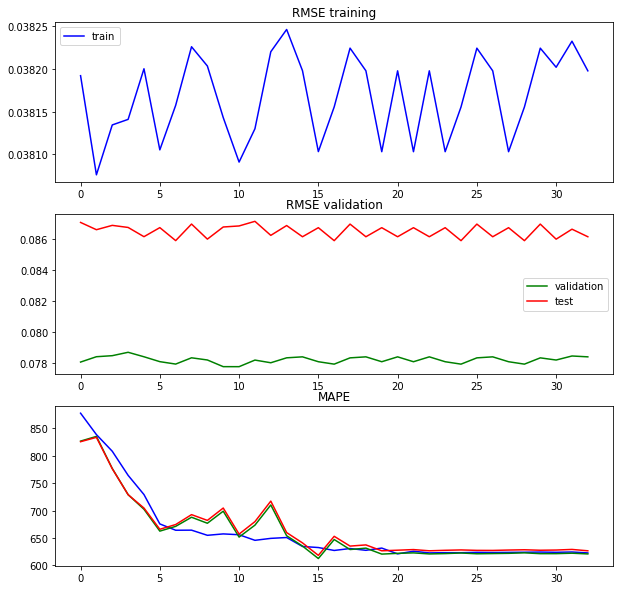

In [ ]:
#будуємо графіки
fig, ax = plt.subplots(nrows = 3, figsize=(10, 10))

ax[0].plot(range(len(train_rmse_list)), train_rmse_list, color = "blue", label = "train")
ax[0].legend()
ax[0].set_title("RMSE training")

ax[1].plot(range(len(val_rmse_list)), val_rmse_list, color = "green", label = "validation")
ax[1].plot(range(len(test_rmse_list)), test_rmse_list, color = "red", label = "test")
ax[1].legend()
ax[1].set_title("RMSE validation")

ax[2].plot(range(len(train_mape_list)), train_mape_list, color = "blue", label = "train")
ax[2].plot(range(len(val_mape_list)), val_mape_list, color = "green", label = "validation")
ax[2].plot(range(len(test_mape_list)), test_mape_list, color = "red", label = "test")
ax[2].set_title("MAPE")

<P>Найкращі отримані результати</P>